In [3]:
# This notebook performs Exploratory Data Analysis (EDA) on the combined NHIS 2021–2023 adult dataset.
# EDA is used to understand data structure, missingness, outcome prevalence, and relationships between predictors and mental health outcomes.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# This cell loads the combined NHIS dataset that was previously created by stacking 2021–2023.
# It checks both the workspace and the OneDrive project folder.

import os
combined_local = 'nhis_2021_2023_combined.csv'
combined_onedrive = os.path.join(os.path.expanduser('~'), 'OneDrive', 'Documents', 'CSST MASTERS PROJECT', 'nhis_2021_2023_combined.csv')
if os.path.exists(combined_local):
    df = pd.read_csv(combined_local)
    print(f'Loaded df from {combined_local}')
elif os.path.exists(combined_onedrive):
    df = pd.read_csv(combined_onedrive)
    print(f'Loaded df from {combined_onedrive}')
else:
    raise FileNotFoundError('nhis_2021_2023_combined.csv not found in workspace or OneDrive CSST MASTERS PROJECT folder')
print(df.shape)
df.head()


(86655, 821)


,ACUHLTH_A,ACUPAIN_A,ACU_A,ADVACTIVE_A,AFNOW,AFVETTRN_A,AFVET_A,AGE65,AGEP_A,AHEARST1_A,...,YOGABRTH_A,YOGAHLTH_A,YOGAMED_A,YOGAPAIN_A,YOGA_A,YRSINUS_A,ZOSTAVAX1_A,ZOSTAVXYRP_A,ZOSTAWHEN_A,eRECTYPE
0,NaN,NaN,NaN,NaN,2.0,NaN,2,NaN,50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,2.0,NaN,2,NaN,53,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,2.0,2.0,1,NaN,56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,2,NaN,57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,2.0,NaN,8,NaN,25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# This cell summarises the dataset structure including variable types and basic descriptive information.

print("Rows, Columns:", df.shape)
df.info()


Rows, Columns: (86655, 821)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86655 entries, 0 to 86654
Columns: 821 entries, ACUHLTH_A to eRECTYPE
dtypes: float64(679), int64(141), object(1)
memory usage: 542.8+ MB


In [6]:
# This cell selects the mental health outcome variable for EDA.
# EDA is typically performed with the same target used in modelling to keep the narrative consistent.

TARGET = "K6SPD_A"   # or "DEPEV_A", "ANXEV_A"
df[TARGET].value_counts(dropna=False).head(20)


K6SPD_A
NaN    57173
2.0    27599
1.0     1012
8.0      871
Name: count, dtype: int64

In [7]:
# This cell standardises NHIS yes/no coding to binary for easier EDA plots.
# 1 = Yes -> 1, 2 = No -> 0, other codes -> missing

def nhis_yesno_to_binary(x):
    if x == 1: return 1
    if x == 2: return 0
    return np.nan

df["_target_bin"] = df[TARGET].apply(nhis_yesno_to_binary)
df["_target_bin"].value_counts(dropna=False)


_target_bin
NaN    58044
0.0    27599
1.0     1012
Name: count, dtype: int64

In [8]:
# This cell summarises the dataset across survey years (repeated cross-sectional structure),
# showing sample size and outcome prevalence by year.

year_counts = df.groupby("SRVY_YR").size().rename("n_records").reset_index()

tmp = df[df["_target_bin"].notna()].copy()
prev = tmp.groupby("SRVY_YR")["_target_bin"].mean().rename("prevalence").reset_index()

year_summary = year_counts.merge(prev, on="SRVY_YR", how="left")
year_summary


,SRVY_YR,n_records,prevalence
0,2021,29482,0.035371
1,2022,27651,NaN
2,2023,29522,NaN


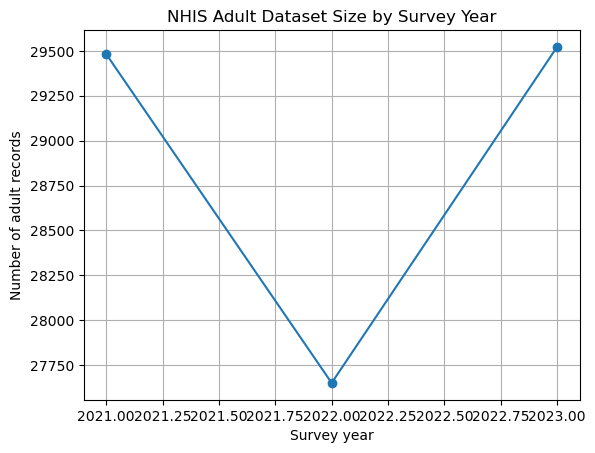

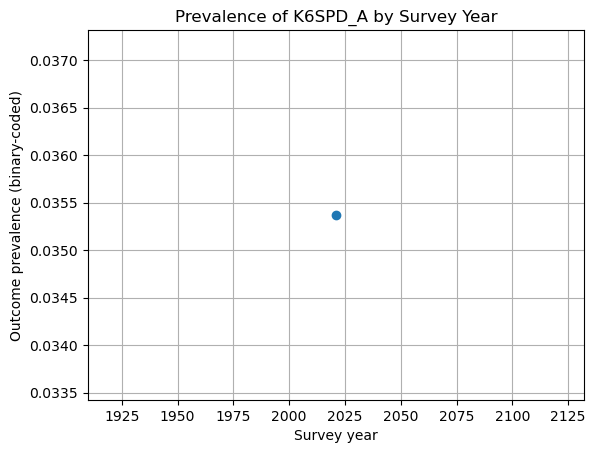

In [9]:
# This cell visualises sample size and outcome prevalence across survey years.

plt.figure()
plt.plot(year_summary["SRVY_YR"], year_summary["n_records"], marker="o")
plt.xlabel("Survey year")
plt.ylabel("Number of adult records")
plt.title("NHIS Adult Dataset Size by Survey Year")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(year_summary["SRVY_YR"], year_summary["prevalence"], marker="o")
plt.xlabel("Survey year")
plt.ylabel("Outcome prevalence (binary-coded)")
plt.title(f"Prevalence of {TARGET} by Survey Year")
plt.grid(True)
plt.show()


In [11]:
# This cell computes missingness proportion per variable to identify variables that may be unsuitable for modelling.

missing = df.isna().mean().sort_values(ascending=False)
missing.head(20)


CHFLG_A         1.000000
OGFLG_A         0.999988
OPFLG_A         0.999954
PRPLCOV2_C_A    0.999954
CHHDHP_A        0.999954
GALLBAGETC_A    0.999838
LARYNAGETC_A    0.999804
CHXCHNG_A       0.999792
CHPREM_A        0.999792
CHDEDUC_A       0.999792
ESOPHAGETC_A    0.999527
INJFALLWRK_A    0.999492
MOUTHAGETC_A    0.999435
PANCRAGETC_A    0.999365
RECTUAGETC_A    0.999342
LIVERAGETC_A    0.999308
STOMAAGETC_A    0.999285
OGHDHP_A        0.999238
BONEAGETC_A     0.999204
BRAINAGETC_A    0.999158
dtype: float64

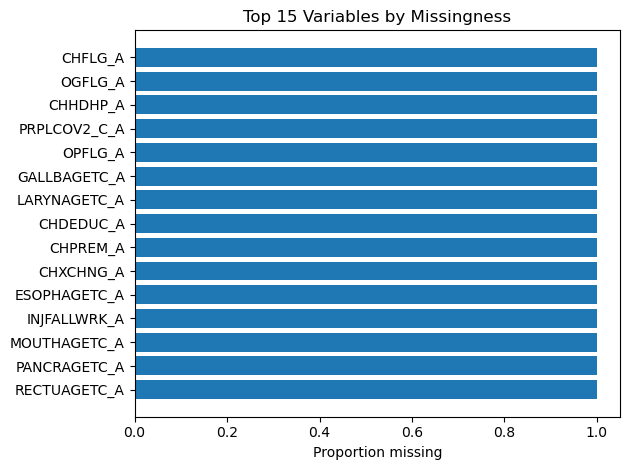

In [12]:
# This cell plots missingness for the most incomplete variables to support decisions about feature inclusion/exclusion.

top_missing = missing.head(15).sort_values()

plt.figure()
plt.barh(top_missing.index, top_missing.values)
plt.xlabel("Proportion missing")
plt.title("Top 15 Variables by Missingness")
plt.tight_layout()
plt.show()


In [13]:
# This cell selects a small set of key demographic and socioeconomic predictors for EDA.
# Use variables that exist in all years where possible.

eda_vars = ["AGEP_A", "SEX_A", "EDUCP_A", "REGION", "URBRRL", "MARITAL_A", "PHSTAT_A"]
eda_vars = [c for c in eda_vars if c in df.columns]

eda_df = df[eda_vars + ["SRVY_YR", "_target_bin"]].copy()
eda_df.shape, eda_vars


((86655, 9),
 ['AGEP_A', 'SEX_A', 'EDUCP_A', 'REGION', 'URBRRL', 'MARITAL_A', 'PHSTAT_A'])

In [14]:
# This cell computes outcome prevalence by selected categorical predictors (e.g., sex, region).
# This supports RQ1/RQ2 by showing distributional differences.

cat_vars = [c for c in ["SEX_A", "REGION", "URBRRL", "MARITAL_A", "EDUCP_A", "PHSTAT_A"] if c in eda_df.columns]

for c in cat_vars:
    tab = eda_df.groupby(c)["_target_bin"].mean().sort_values(ascending=False)
    print("\nOutcome prevalence by", c)
    print(tab.head(20))



Outcome prevalence by SEX_A
SEX_A
2    0.042099
1    0.027275
7    0.000000
9    0.000000
Name: _target_bin, dtype: float64

Outcome prevalence by REGION
REGION
3    0.037511
2    0.036989
4    0.033967
1    0.030626
Name: _target_bin, dtype: float64

Outcome prevalence by URBRRL
URBRRL
4    0.046423
3    0.036402
1    0.033930
2    0.028962
Name: _target_bin, dtype: float64

Outcome prevalence by MARITAL_A
MARITAL_A
9    0.333333
8    0.055118
3    0.047355
2    0.042888
7    0.025000
1    0.022079
Name: _target_bin, dtype: float64

Outcome prevalence by EDUCP_A
EDUCP_A
3     0.074960
99    0.066667
1     0.066023
2     0.051685
5     0.045812
4     0.042770
6     0.037409
7     0.035899
8     0.021765
97    0.021739
9     0.013993
10    0.009009
Name: _target_bin, dtype: float64

Outcome prevalence by PHSTAT_A
PHSTAT_A
5    0.223881
9    0.200000
4    0.091986
3    0.037216
2    0.013956
1    0.010340
7    0.000000
Name: _target_bin, dtype: float64


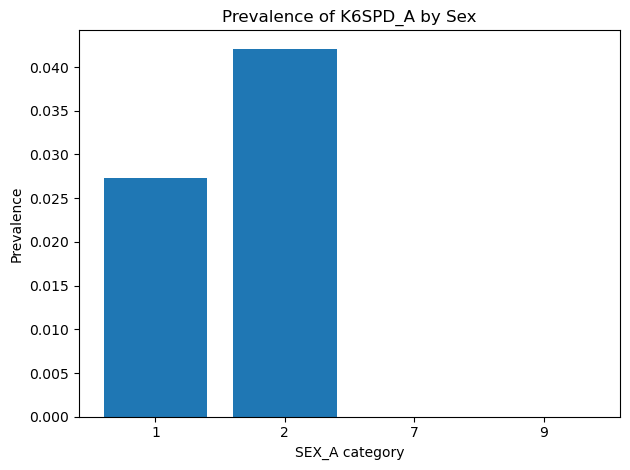

In [15]:
# This cell visualises outcome prevalence by sex (if SEX_A exists).

if "SEX_A" in eda_df.columns:
    by_sex = eda_df.groupby("SEX_A")["_target_bin"].mean()

    plt.figure()
    plt.bar(by_sex.index.astype(str), by_sex.values)
    plt.xlabel("SEX_A category")
    plt.ylabel("Prevalence")
    plt.title(f"Prevalence of {TARGET} by Sex")
    plt.tight_layout()
    plt.show()


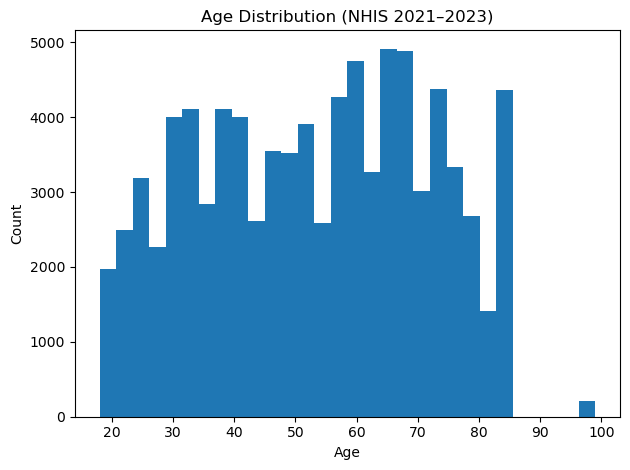

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24848\2617826905.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_prev = eda_df.groupby("age_band")["_target_bin"].mean()


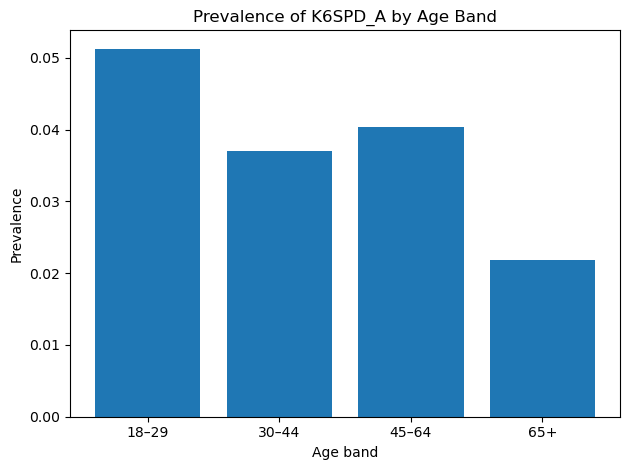

In [16]:
# This cell explores the distribution of age and compares outcome prevalence across age groups.

if "AGEP_A" in eda_df.columns:
    plt.figure()
    plt.hist(eda_df["AGEP_A"].dropna(), bins=30)
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.title("Age Distribution (NHIS 2021–2023)")
    plt.tight_layout()
    plt.show()

    # Age bands for prevalence
    bins = [18, 30, 45, 65, 120]
    labels = ["18–29", "30–44", "45–64", "65+"]
    eda_df["age_band"] = pd.cut(eda_df["AGEP_A"], bins=bins, labels=labels, right=False)

    age_prev = eda_df.groupby("age_band")["_target_bin"].mean()
    plt.figure()
    plt.bar(age_prev.index.astype(str), age_prev.values)
    plt.xlabel("Age band")
    plt.ylabel("Prevalence")
    plt.title(f"Prevalence of {TARGET} by Age Band")
    plt.tight_layout()
    plt.show()


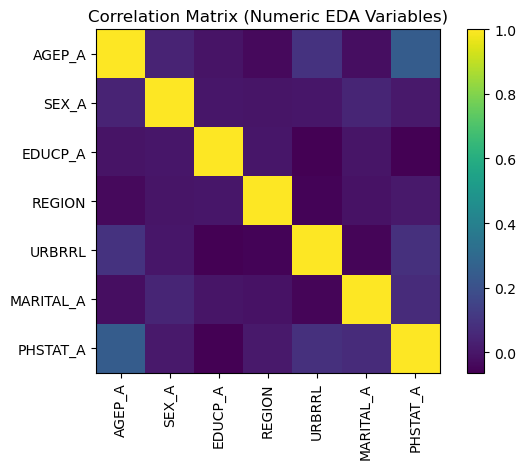

Saved: eda_year_summary.csv and eda_missingness.csv


In [17]:
# This cell provides a simple correlation matrix for numeric predictors to identify strong relationships.
# It is used only as an exploratory tool (not causal inference).

num_cols = [c for c in eda_vars if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)

    plt.figure()
    plt.imshow(corr.values)
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation Matrix (Numeric EDA Variables)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
# This cell saves summary outputs that can be inserted into the dissertation.
# It exports year-by-year summary and missingness table.

year_summary.to_csv("eda_year_summary.csv", index=False)
missing.reset_index().rename(columns={"index": "variable", 0: "missing_rate"}).to_csv("eda_missingness.csv", index=False)

print("Saved: eda_year_summary.csv and eda_missingness.csv")


In [48]:
# This cell saves summary outputs that can be inserted into the dissertation.
# It exports year-by-year summary and missingness table.

year_summary.to_csv("eda_year_summary.csv", index=False)
missing.reset_index().rename(columns={"index": "variable", 0: "missing_rate"}).to_csv("eda_missingness.csv", index=False)

print("Saved: eda_year_summary.csv and eda_missingness.csv")


Saved: eda_year_summary.csv and eda_missingness.csv
